
## To induce SP in rates

The Berekely admissions version of SP is what we will call rate based.  This requires 


2 grouping varibles & a binary
 - binary `decision` variable that will have a rate that flips (eg admission decision)
 - 1 `protected class` grouping variable that that will be how the rates are compared, eg gender (likely 2 levels, can possibly generalize)
 - 1 `explanatory` grouping variable eg has class imbalance
 
An open problem is to determine if we can define a mixed case where we use continuous variables to define the decsion variable.




In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pylab as plt

The causal explanation for rate-based SP is that the application rates by gender varied in a way that was correlated with the department size and/or acceptance rate.  Here we create a model that will, for most samples, have SP for some departments. We only set the portion of applications to each department, the rate of each gender applying to each department and each department's acceptance rate.  

In [2]:
p_dept = [.15,.15,.1,.6]
p_gender_dept = [[.7, .3],[.8,.2],[.85,.15],[.2,.8]]
gender_list = ['F','M']
p_admit_dept = [[.15,.85], [.18,.82], [.25,.75],[.3,.7]]
# need to have higher accept in the larger subgroup, larger subgroup should have opposite protected class balance
N = 1000

d = np.random.choice(list(range(len(p_dept))), size=N, p =p_dept)
g = [np.random.choice(gender_list, p =p_gender_dept[d_i]) for d_i in d]
a = [np.random.choice([1,0],p = p_admit_dept[d_i]) for d_i in d]
data = [[d_i,g_i,a_i] for d_i, g_i,a_i in zip(d,g,a)]

df = pd.DataFrame(data = data, columns=['department','gender','decision'])

p_race_dept = [[.8,.1,.1], [.7,.13,.17],[.5,.2,.3],[.85,.07,.08]]
race_list = ['W','B','H']

r = [np.random.choice(race_list, p =p_race_dept[d_i]) for d_i in d]
df['race'] = r
df.head()

,department,gender,decision,race
0,0,F,0,W
1,0,F,0,W
2,3,F,0,H
3,1,F,1,W
4,3,M,0,W


We can check that the probabilities match what we set.  First the per-department admission rate.

In [3]:
actual_admit_dept = df.groupby(['department']).mean()
expected_admit_dept = [p[0] for p in p_admit_dept]
actual_admit_dept['expected'] = expected_admit_dept
actual_admit_dept

,decision,expected
department,,
0,0.112782,0.15
1,0.185430,0.18
2,0.200000,0.25
3,0.313099,0.30


In [4]:
actual_app_dept = df.groupby(['department'])['gender'].value_counts().unstack()
actual_app_dept

gender,F,M
department,,
0,91,42
1,129,22
2,73,17
3,132,494


In [5]:
expected_app_dept_dat = [[p_d[0]*n_d, p_d[1]*n_d] for p_d,n_d in zip(p_gender_dept,[p*N for p in p_dept])]
expected_app_dept = pd.DataFrame(data = expected_app_dept_dat, columns = gender_list)
expected_app_dept

,F,M
0,105.0,45.0
1,120.0,30.0
2,85.0,15.0
3,120.0,480.0


Next we can look for SP

In [6]:
df.groupby('gender')['decision'].mean()

gender
F    0.204706
M    0.295652
Name: decision, dtype: float64

In [7]:
df.groupby(['gender','department']).mean().unstack()

decision                              
department         0         1         2         3
gender                                            
F           0.120879  0.193798  0.178082  0.287879
M           0.095238  0.136364  0.294118  0.319838

To detect SP, we compare which group is the highest in the overall to to which group is highest in each of the departments. 

In [8]:
overall_dat = df.groupby('gender')['decision'].mean()
per_dept_dat = df.groupby(['gender','department']).mean().unstack()

overall_dat.values[0]/overall_dat.values[1]
per_dept_dat.values[0]/per_dept_dat.values[1] /(overall_dat.values[0]/overall_dat.values[1])

array([1.8331219 , 2.05259128, 0.87448057, 1.29996087])

In [9]:
per_dept_dat.values[0]/per_dept_dat.values[1] /(overall_dat.values[0]/overall_dat.values[1])

array([1.8331219 , 2.05259128, 0.87448057, 1.29996087])

In [10]:
df.to_csv('synthetic_admission_high_sp.csv',index=False)

In [11]:
# now detect and compare which trends
overall = df.groupby('gender')['decision'].mean().idxmax()
print('overall more admitted: ', overall)

per_dept = [gender_list[g] for g in np.argmax(df.groupby(['gender','department']).mean().unstack().values,axis=0)]
print('per dept more addmitted:', per_dept)
# it's sp for each dept that is not the same as the overall
[not(dept==overall) for dept in per_dept]

overall more admitted:  M
per dept more addmitted: ['F', 'F', 'M', 'M']


[True, True, False, False]

Now, we can run it a bunch more times and count how many SP in each trial, to see how reliable it is.

In [12]:
sp_occ = []

for i in range(20):
    p_dept = [.15,.15,.1,.6]
    p_gender_dept = [[.7, .3],[.8,.2],[.85,.15],[.2,.8]]
    gender_list = ['F','M']
    p_admit_dept = [[.15,.85], [.18,.82], [.25,.75],[.3,.7]]
    # need to have higher accept in the larger subgroup, larger subgroup should have opposite protected class balance
    N = 1000

    d = np.random.choice(list(range(len(p_dept))), size=N, p =p_dept)
    g = [np.random.choice(gender_list, p =p_gender_dept[d_i]) for d_i in d]
    a = [np.random.choice([1,0],p = p_admit_dept[d_i]) for d_i in d]
    data = [[d_i,g_i,a_i] for d_i, g_i,a_i in zip(d,g,a)]

    df = pd.DataFrame(data = data, columns=['department','gender','decision'])

    overall = df.groupby('gender')['decision'].mean().idxmax()
    per_dept = [gender_list[g] for g in np.argmax(df.groupby(['gender','department']).mean().unstack().values,axis=0)]


    sp_occ.append(sum([not(dept==overall) for dept in per_dept]))
    
sp_occ

[2, 2, 2, 4, 3, 3, 0, 2, 3, 3, 2, 2, 3, 3, 2, 0, 2, 2, 0, 3]

We see from above that it generates SP most of the time but a varialbe number of times for the exact same settings to this sampling method does not reliably induce SP, it does show that, with no malintent that SP can occur.  

# intentional SP

To more reliably induce rate based SP we should sample less independently.  


In [13]:
p_dept = [.15,.2,.1,.55]
p_gender_dept = [[.7, .3],[.8,.2],[.85,.15],[.2,.8]]
gender_list = ['F','M']
p_admit_dept_gender = [{'F':.18,'M':.12},{'F':.17,'M':.1},
                       {'F':.30,'M':.27},{'F':.35,'M':.30}] 
# need to have higher accept in the larger subgroup, larger subgroup should have opposite protected class balance
N = 1000

d = np.random.choice(list(range(len(p_dept))), size=N, p =p_dept)
g = [np.random.choice(gender_list, p =p_gender_dept[d_i]) for d_i in d]
p_admit =[ p_admit_dept_gender[d_i][g_i] for d_i,g_i in zip(d,g)]
p_admit
a = [np.random.choice([1,0], p = [p,1-p]) for p in p_admit]
data = [[d_i,g_i,a_i] for d_i, g_i,a_i in zip(d,g,a)]

df = pd.DataFrame(data = data, columns=['department','gender','decision'])
df.head()

,department,gender,decision
0,1,M,0
1,1,F,0
2,3,M,0
3,0,F,1
4,3,M,1


In [14]:
p_admit_dept_gender[1]['M']

0.1

In [352]:
df.groupby('gender')['decision'].mean()

gender
F    0.222222
M    0.242144
Name: decision, dtype: float64

In [358]:
gen_dep = df.groupby(['gender','department']).mean().unstack() #.reset_index()
gen_dep['total'] = df.groupby('gender')['decision'].mean().values
gen_dep

decision                                   total
department         0         1         2         3          
gender                                                      
F           0.212121  0.136364  0.240506  0.361905  0.222222
M           0.024390  0.071429  0.250000  0.285047  0.242144

In [17]:
overall_dat = df.groupby('gender')['decision'].mean()
per_dept_dat = df.groupby(['gender','department']).mean().unstack()

overall_dat.values[0]/overall_dat.values[1]
per_dept_dat.values[0]/per_dept_dat.values[1] /(overall_dat.values[0]/overall_dat.values[1])

array([9.47664258, 2.08023862, 1.04826973, 1.38345418])

In [18]:
overall = df.groupby('gender')['decision'].mean().idxmax()

per_dept = [gender_list[g] for g in np.argmax(df.groupby(['gender','department']).mean().unstack().values,axis=0)]


[not(dept==overall) for dept in per_dept]

[True, True, False, True]

We can try to use 3 categories and do an ordering swap detection, maybe?

In [19]:

p_race_dept = [[.8,.1,.1], [.7,.13,.17],[.5,.2,.3],[.85,.07,.08]]
race_list = ['W','B','H']

r = [np.random.choice(race_list, p =p_race_dept[d_i]) for d_i in d]
df['race'] = r

In [20]:
df.groupby('race')['decision'].mean()

race
B    0.234694
H    0.187500
W    0.240310
Name: decision, dtype: float64

In [21]:
df.groupby(['race','department']).mean().unstack()

decision                              
department         0         1         2         3
race                                              
B           0.153846  0.166667  0.117647  0.368421
H           0.142857  0.105263  0.241379  0.234043
W           0.159292  0.115854  0.285714  0.301339

In [22]:
df.head()

,department,gender,decision,race
0,1,M,0,B
1,1,F,0,W
2,3,M,0,W
3,0,F,1,W
4,3,M,1,W


# Generalizing this framework

First we provide general variables and separate the set parts from the sampling. 

In [23]:
# must have imbalance
p_explanatory = [.15,.2,.1,.55]
#protected, given explantory, largest explantory should have fipped rates
# larger subgroup should have opposite protected class balance
p_protected_explanatory = [[.7, .3],[.8,.2],[.85,.15],[.2,.8]]

# need to have higher accept in the larger subgroup,
p_outcome_all = [{'F':.18,'M':.12},{'F':.17,'M':.1},
                       {'F':.30,'M':.27},{'F':.35,'M':.30}]
N = 1000

def gen_rate(N, p_explanatory, p_protected_explanatory,p_outcome_all):
    """
    sampler that takes in probabilities 
    
    Parameters
    ----------
    N : scalar
        number of samples to draw
    """
    protected_list = ['F','M']
    explantory = np.random.choice(list(range(len(p_explanatory))),
                                    size=N, p =p_explanatory)
    protected = [np.random.choice(protected_list, p=p_protected_explanatory[e])
                                    for e in explantory]
    p_outcome =[ p_outcome_all[e][p] for e,p in zip(explantory,protected)]

    outcome = [np.random.choice([1,0], p = [p,1-p]) for p in p_outcome]
    data = [[e,p,o] for e,p,o in zip(explantory,protected,outcome)]

    df = pd.DataFrame(data = data, columns=['explanatory','protected','outcome'])
    
    return df

In [24]:
df_gen = gen_rate(N, p_explanatory, p_protected_explanatory,p_outcome_all)
df_gen.head()

,explanatory,protected,outcome
0,3,M,1
1,3,M,0
2,0,M,0
3,3,M,1
4,0,F,1


Next, we need to determin how to sample the probabilities such that we get the balances needed and how to parameterize. To facilitate this, we'll make a sample detector for testing. 

In [322]:
df_gen.groupby('protected')['outcome'].mean().reset_index().sort_values(by='outcome',ascending=False)['protected'].values

array(['M', 'F'], dtype=object)

In [347]:
list(set(df_gen['explanatory']))

[0, 1, 2, 3]

In [340]:
df_gen.groupby(['protected','explanatory'])['outcome'].mean().unstack().reset_index().sort_values(by=1,ascending=False)['protected']

1    M
0    F
Name: protected, dtype: object

In [25]:

def check_sp_rate(df_rate):
    """rate specific sp detector"""
    overall = df_rate.groupby('protected')['outcome'].mean().idxmax()

    per_group = df_rate.groupby(['protected','explanatory']).mean().unstack().idxmax()

    
    return [not(group==overall) for group in per_group]


In [26]:
check_sp_rate(df_gen)

[True, False, False, True]

In [27]:
sum(check_sp_rate(df_gen))

2

In [28]:
sp_counts = []
for i in range(100):
    sp_counts.append(check_sp_rate(gen_rate(N, p_explanatory, p_protected_explanatory,p_outcome_all)))

sp_counts_df = pd.DataFrame(data = sp_counts,columns = set(df_gen['explanatory']))

sp_counts_df['count'] = sp_counts_df.sum(axis=1)

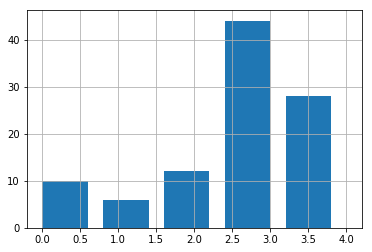

In [29]:
sp_counts_df['count'].hist(bins=len(set(df_gen['explanatory']))+1,width = .6,align='mid')

In [30]:
df_gen.groupby(['explanatory','protected']).mean().unstack()

outcome          
protected           F         M
explanatory                    
0            0.178218  0.042553
1            0.130952  0.162162
2            0.285714  0.375000
3            0.392523  0.294931

In [31]:
p_outcome_all

[{'F': 0.18, 'M': 0.12},
 {'F': 0.17, 'M': 0.1},
 {'F': 0.3, 'M': 0.27},
 {'F': 0.35, 'M': 0.3}]

There is some disparity there, but lets try with more values of N

In [32]:
sp_counts = []
n_list = [100,1000,10000]
for N_cur in n_list:
    for i in range(100):
        sp_counts.append(check_sp_rate(gen_rate(N_cur, p_explanatory, p_protected_explanatory,p_outcome_all)))

    sp_counts_df = pd.DataFrame(data = sp_counts,columns = set(df_gen['explanatory']))

sp_counts_df['count'] = sp_counts_df.sum(axis=1)

In [33]:
p_explanatory


[0.15, 0.2, 0.1, 0.55]

In [34]:
p_protected_explanatory

[[0.7, 0.3], [0.8, 0.2], [0.85, 0.15], [0.2, 0.8]]

In [35]:
total_rate = [[portion*g for g in g_breakdown] for portion,g_breakdown in zip(p_explanatory,p_protected_explanatory)]
total_rate

[[0.105, 0.045],
 [0.16000000000000003, 0.04000000000000001],
 [0.085, 0.015],
 [0.11000000000000001, 0.44000000000000006]]

In [36]:
total_admit_planned = [ [p*a for p,a in zip(d_p,d_a.values())] for d_p,d_a in zip(total_rate,p_outcome_all)]
total_admit_planned

[[0.0189, 0.005399999999999999],
 [0.02720000000000001, 0.004000000000000001],
 [0.025500000000000002, 0.00405],
 [0.0385, 0.132]]

In [39]:
np.sum(np.array(total_admit),axis=0)

NameError: name 'total_admit' is not defined

In [40]:
np.sum(np.array(total_rate),axis=0)

array([0.46, 0.54])

In [41]:
np.sum(np.array(total_admit),axis=0)/np.sum(np.array(total_rate),axis=0)

NameError: name 'total_admit' is not defined

In [42]:
 df_gen.groupby('protected')['outcome'].mean()

protected
F    0.271739
M    0.250000
Name: outcome, dtype: float64

# Sampling the rates

We can sample the individuals if we have rates, so now we need to figure ot how to sample the rates tushc that SP happens.


In [37]:
p_explanatory = np.asarray([.15,.2,.1,.55])
#protected, given explantory, largest explantory should have fipped rates
# larger subgroup should have opposite protected class balance
p_protected_explanatory = np.asarray([[.7, .3],[.8,.2],[.85,.15],[.2,.8]])

# need to have higher accept in the larger subgroup,
p_outcome_all = [{'F':.18,'M':.12},{'F':.17,'M':.1},
                       {'F':.30,'M':.27},{'F':.35,'M':.30}]

First, lets compute the expected overall and per dept rates of admission by gender from these probabilities

In [38]:
protected_portion_dept = [p_e*p_ep for  p_ep, p_e in zip(p_protected_explanatory,p_explanatory)]
protected_portion_dept

[array([0.105, 0.045]),
 array([0.16, 0.04]),
 array([0.085, 0.015]),
 array([0.11, 0.44])]

In [39]:

outcome_protected_dept_total = [share*list(p_outcome.values()) for 
                          p_outcome,share in zip( p_outcome_all,protected_portion_dept)]

p_outcome_total = sum(outcome_protected_dept_total)/sum(protected_portion_dept)
p_outcome_total

array([0.23934783, 0.26935185])

This says that SP should occur, we can check below

In [40]:
np.argmax(p_outcome_total)

1

In [41]:
[np.argmax(exp) for exp in p_outcome_all]

[0, 0, 0, 0]

So, we expect SP, but as we saw above, it didn't happen every time

# Iterative sampling

In [237]:
n_depts = 4
p_protected_explanatory = np.random.dirichlet([25,10],n_depts)
flip_dept = np.random.choice(n_depts)
p_protected_explanatory[flip_dept] = np.flip(p_protected_explanatory[flip_dept],0)
p_protected_explanatory

array([[0.7259675 , 0.2740325 ],
       [0.29833329, 0.70166671],
       [0.70091547, 0.29908453],
       [0.78208891, 0.21791109]])

In [238]:
alpha_dept = [1]*n_depts
alpha_dept[flip_dept] = 7.5
p_explanatory = np.random.dirichlet(alpha_dept)
p_explanatory

array([0.0581168 , 0.75252521, 0.02036134, 0.16899666])

In [239]:
protected_portion_dept = [p_e*p_ep for  p_ep, p_e in zip(p_protected_explanatory,p_explanatory)]
protected_portion_dept

[array([0.04219091, 0.01592589]),
 array([0.22450332, 0.52802189]),
 array([0.01427158, 0.00608976]),
 array([0.13217041, 0.03682625])]

In [240]:
sum(protected_portion_dept)

array([0.41313622, 0.58686378])

In [242]:
p_outcome_all_v =  [np.min(np.random.dirichlet([rho*2+1]*3)) for rho in p_explanatory]
psi = [p*ps for p, ps in zip(p_outcome_all_v,np.min(np.random.dirichlet([.75]*2,n_depts),axis=1))]
psi = [[psi1,-p[0]/p[1]*psi1] for p,psi1 in zip(p_protected_explanatory,psi)]
p_outcome_all = [{'F':r+p[0],'M':r+p[1]} for r,p in zip( p_outcome_all_v,psi)]
p_outcome_all

[{'F': 0.10122997341747773, 'M': 0.03673910297312686},
 {'F': 0.12473379838978653, 'M': 0.1229974208468655},
 {'F': 0.2276749948114404, 'M': 0.09321830601697341},
 {'F': 0.25474275110241185, 'M': 0.08044964239426569}]

In [309]:
p_outcome_all_v =  [np.min(np.random.dirichlet([rho*2+1]*3)) for rho in p_explanatory]
p_outcome_all_v

[0.012738227821703023,
 0.1262949171811066,
 0.12315234329784283,
 0.07293366439844567]

In [310]:
psi = [[min(p)+1, max(p)] for p in np.random.dirichlet([.75]*2,n_depts)]
p_outcome_all = [{'F':r*p[0],'M':r} for r,p in zip( p_outcome_all_v,psi)]
p_outcome_all

[{'F': 0.01491863901464531, 'M': 0.012738227821703023},
 {'F': 0.13562971772916244, 'M': 0.1262949171811066},
 {'F': 0.12699448665783367, 'M': 0.12315234329784283},
 {'F': 0.10070953112500737, 'M': 0.07293366439844567}]

In [311]:

outcome_protected_dept_total = [share*list(p_outcome.values()) for 
                          p_outcome,share in zip( p_outcome_all,protected_portion_dept)]

p_outcome_total = sum(outcome_protected_dept_total)/sum(protected_portion_dept)
p_outcome_total

array([0.11183233, 0.11983222])

In [296]:
p_outcome_all

[{'F': 0.05407806117378226, 'M': 0.05223938242678653},
 {'F': 0.29689645189109615, 'M': 0.2418143791857533},
 {'F': 0.15928054334741978, 'M': 0.14811589625740104},
 {'F': 0.3089768006784981, 'M': 0.25699089188892477}]